In [1]:
import sys, gc, math
import nengo
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.interpolate
from nengo_extras.neurons import (
    rates_kernel, rates_isi, spikes2events )
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance, sample_by_activity)
from nengo.utils.progress import TerminalProgressBar
from nengo.utils.ensemble import response_curves, tuning_curves
from nengo.dists import Choice, Uniform
from nengo_extras.dists import Tile
from nengo_extras.matplotlib import tile
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model
from nengo_extras.gui import image_display_function, preprocess_display
from digits_data import generate_inputs
from inputs import Mask, SequentialMask, Gabor, OOCS
from inputs import PresentInputWithPause
from prf_net import PRF
from decoding import predict_ngram, fit_ngram_decoder, fit_rate_decoder, predict_rate


In [2]:
import importlib
import decoding
importlib.reload(decoding)
from decoding import predict_ngram, fit_ngram_decoder, fit_rate_decoder, predict_rate


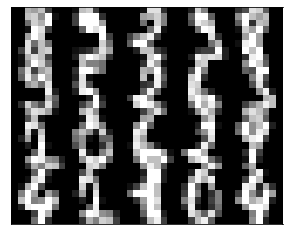

[6 3 9 0 0 7 4 6 4 5 4 5 0 5 7 0 9 9 1 5]


In [3]:
seed=23
presentation_time=0.06
pause_time=0.1
skip_time=0.0

train_size=80
test_size=20

train_image_array, train_labels = generate_inputs(plot=True, train_size=train_size, dataset='train', seed=seed)
#test_image_array, test_labels = generate_inputs(plot=True, test_size=test_size, dataset='test', seed=seed)
test_index = np.random.choice(train_size, size=test_size, replace=False)
test_image_array, test_labels = train_image_array[test_index], train_labels[test_index]
print(test_labels)

In [4]:
n_labels = len(np.unique(train_labels))

n_x = train_image_array.shape[1]
n_y = train_image_array.shape[2]


train_image_array = np.concatenate((train_image_array[0].reshape(1,n_x,n_y), train_image_array), axis=0)
train_labels = np.concatenate((np.asarray([train_labels[0]]), train_labels))


Ln = np.linalg.norm(train_image_array[0])
normed_train_image_array = train_image_array / np.linalg.norm(train_image_array, axis=(1,2))[:,np.newaxis,np.newaxis]
normed_test_image_array = test_image_array / np.linalg.norm(test_image_array, axis=(1,2))[:,np.newaxis,np.newaxis]

normed_train_image_array -= np.max(normed_train_image_array) / 2.0
normed_test_image_array -= np.max(normed_test_image_array) / 2.0

input_data = np.concatenate((normed_train_image_array, normed_test_image_array), axis=0)




In [5]:
input_dim = n_x * n_y
image_shape = (1, n_x, n_y)

n_neurons_per_dim = 30
n_ensembles = input_dim

n_outputs=480
n_exc=input_dim*n_neurons_per_dim
n_inh=100

t_train = (train_size+1)*(presentation_time + pause_time)
t_test = test_size*(presentation_time + pause_time)
t_end = t_train + t_test

t_learn_exc=t_train
t_learn_inh=t_end

dt = 0.005
n_steps_frame = int((presentation_time + pause_time) / dt)
n_steps_present = int((presentation_time) / dt)
n_steps_skip = int(skip_time / dt)
n_steps_train = n_steps_frame * (train_size+1)
n_steps_test = n_steps_frame * test_size

rng = np.random.RandomState(seed)

input_encoders = None
# Generate the encoders for the sensory ensemble
#input_encoders = rng.normal(size=(n_exc, 1))
# TODO: implement "dimensionality reduction" encoding scheme where the mask is applied to the n-dim input 
# and then is _reduced_ to 1-D by e.g. summation
# Refer to work on V1: https://arxiv.org/pdf/1509.03942.pdf
#input_encoders = OOCS().generate(n_neurons_per_dim, shape=(3, 3), on_off_frac=1.0)
#input_encoders = SequentialMask((n_x, n_y)).populate(input_encoders, rng=rng, flatten=True)
#tile(input_encoders.reshape((-1, n_x, n_y)), rows=10, cols=10, grid=True)




In [6]:
n_exc_sqrt = math.ceil(np.sqrt(n_exc))
srf_exc_coords = (np.mgrid[range(n_exc), range(n_exc_sqrt)].reshape((2,-1)).T / n_exc_sqrt)[:n_exc]
n_inh_sqrt = math.ceil(np.sqrt(n_inh))
srf_inh_coords = (np.mgrid[range(n_inh_sqrt), range(n_inh_sqrt)].reshape((2,-1)).T / n_inh_sqrt)[:n_inh]
n_output_sqrt = math.ceil(np.sqrt(n_outputs))
srf_output_coords = (np.mgrid[range(n_output_sqrt), range(n_output_sqrt)].reshape((2,-1)).T / n_output_sqrt)[:n_outputs]


coords_dict = { 'srf_output': srf_output_coords,
                'srf_exc': srf_exc_coords,
                'srf_inh': srf_inh_coords,
                }


In [7]:

params = {'w_initial_E':  0.1, 
          'w_initial_EI': 0.01,
          'w_initial_EE': 0.0004,
          'w_initial_I': -0.0001, 
          'w_EI_Ext': 0.00005,
          'w_II': -0.001,
          'p_E_srf': 0.1, 
          'p_I_srf': 0.3,
          'p_EE': 0.05, 
          'p_EI': 0.2,
          'p_EI_Ext': 0.1,
          'p_II_srf': 0.25,
          'tau_E': 0.005, 
          'tau_I': 0.010, 
          'tau_input': 0.015,
          'w_input': 1.0,
          'isp_target_rate_I': 1.0,
          'learning_rate_I': 0.01, 
          'learning_rate_E': 0.2,
          'learning_rate_EE': 0.1,
          'sigma_scale_E': 0.0005,
          'sigma_scale_EI': 0.002,
          'sigma_scale_EI_Ext': 0.002,
          'sigma_scale_EE': 0.001,
          'sigma_scale_I': 0.002,
          }



In [8]:
sample_input_every=1.0
sample_weights_every=5.0


In [9]:
with nengo.Network(label="Digits") as model:

    input_process = PresentInputWithPause(input_data, presentation_time, pause_time)
    input_node = nengo.Node(output=input_process, size_out=input_dim)

    input_ensemble = nengo.networks.EnsembleArray(
        n_neurons=n_neurons_per_dim,
        n_ensembles=input_dim,
        ens_dimensions=1,
        neuron_type=nengo.LIFRate(tau_rc=0.03, tau_ref=0.001),
        intercepts= nengo.dists.Exponential(0.1, shift=0.01, high=1.0),
        max_rates=nengo.dists.Uniform(40, 80)
    )
    input_ensemble.add_neuron_output()
    nengo.Connection(
        input_node, input_ensemble.input
    )
    
    display_func = image_display_function(image_shape,preprocess=lambda x: preprocess_display(x*Ln))
    output_display_node = nengo.Node(display_func, size_in=input_dim)
    input_display_node = nengo.Node(display_func, size_in=input_dim)
    nengo.Connection(input_node, input_display_node, synapse=0.01)
    nengo.Connection(input_ensemble.output, output_display_node, synapse=0.01)

    learning_rate_E = params.get('learning_rate_E', 1e-3)
    learning_rate_EE = params.get('learning_rate_EE', 1e-3)
    learning_rate_I = params.get('learning_rate_I', 1e-4)
    learning_rate_E_func=(lambda t: learning_rate_E if t <= t_learn_exc else 0.0) if t_learn_exc is not None and learning_rate_E is not None else None
    learning_rate_EE_func=(lambda t: learning_rate_EE if t <= t_learn_exc else 0.0) if t_learn_exc is not None and learning_rate_EE is not None else None
    learning_rate_I_func=(lambda t: learning_rate_I if t <= t_learn_inh else 0.0) if t_learn_inh is not None and learning_rate_E is not None else None

    srf_network = PRF(exc_input = input_ensemble.output,
                      
                      dimensions = input_dim,
                      
                      connect_exc_inh_input = True,
                      connect_out_out = True if ('w_initial_EE' in params) and (params['w_initial_EE'] is not None) else False,
                      connect_inh_inh = True,
                      n_excitatory = n_exc,
                      n_inhibitory = n_inh,
                      n_outputs = n_outputs,

                      output_coordinates = srf_output_coords,
                      exc_coordinates = srf_exc_coords,
                      inh_coordinates = srf_inh_coords,

                      w_initial_E = params['w_initial_E'],
                      w_initial_I = params['w_initial_I'],
                      w_initial_EI = params['w_initial_EI'],
                      w_initial_EE = params.get('w_initial_EE', None),
                      w_EI_Ext = params['w_EI_Ext'],
                      w_II = params['w_II'],
                      p_E = params['p_E_srf'],
                      p_I = params['p_I_srf'],
                      p_EE = params['p_EE'],
                      p_EI_Ext = params['p_EI_Ext'],
                      p_EI = params['p_EI'],
                      p_II = params['p_II_srf'],
                      tau_E = params['tau_E'],
                      tau_I = params['tau_I'],
                      tau_input = params['tau_input'],
                      w_input = params['w_input'],
                      learning_rate_I=learning_rate_I,
                      learning_rate_E=learning_rate_E,
                      learning_rate_EE=learning_rate_EE,
                      learning_rate_E_func=learning_rate_E_func,
                      learning_rate_EE_func=learning_rate_EE_func,
                      learning_rate_I_func=learning_rate_I_func,
                      sigma_scale_E = params['sigma_scale_E'],
                      sigma_scale_EI = params['sigma_scale_EI'],
                      sigma_scale_EI_Ext = params['sigma_scale_EI_Ext'],
                      sigma_scale_EE = params['sigma_scale_EE'],
                      sigma_scale_I = params['sigma_scale_I'],
                      isp_target_rate_I = params['isp_target_rate_I'],
                      direct_input = False,
                      label="Spatial receptive field network",
                      use_stdp=True,
                      seed=seed)

    if input_encoders is not None:
        srf_network.exc_ens.encoders = input_encoders

    p_srf_output_spikes = nengo.Probe(srf_network.output.neurons, 'output', synapse=None)
    p_srf_exc_spikes = nengo.Probe(srf_network.exc_ens.neurons, 'output', synapse=None)
    p_srf_inh_spikes = nengo.Probe(srf_network.inh_ens.neurons, 'output', synapse=None)
    p_srf_input = nengo.Probe(srf_network.output, synapse=0.1, sample_every=sample_input_every)
    p_srf_output_voltage = nengo.Probe(srf_network.output.neurons, 'voltage', synapse=None, sample_every=0.5)

    p_srf_inh_weights = nengo.Probe(srf_network.conn_I, 'weights', sample_every=sample_weights_every)
    p_srf_exc_weights = nengo.Probe(srf_network.conn_E, 'weights', sample_every=sample_weights_every)
    if srf_network.conn_EE is not None:
        p_srf_rec_weights = nengo.Probe(srf_network.conn_EE, 'weights', sample_every=sample_weights_every)

    model_dict =  { 'model': model,
                    'neuron_probes': {'srf_output_spikes': p_srf_output_spikes,
                                      'srf_exc_spikes': p_srf_exc_spikes,
                                      'srf_inh_spikes': p_srf_inh_spikes,
                                      'srf_input': p_srf_input,
                                      'srf_output_voltage': p_srf_output_voltage,
                    },
                    'weight_probes': { 'srf_exc_weights': p_srf_exc_weights,
                                       'srf_rec_weights': p_srf_rec_weights,
                                       'srf_inh_weights': p_srf_inh_weights,
                    }
    }



In [10]:
print(srf_network.output.neurons.probeable)
print(srf_network.inh_ens.neurons.probeable)


('output', 'voltage', 'refractory_time', 'adaptation', 'input')
('output', 'voltage', 'refractory_time', 'input')


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

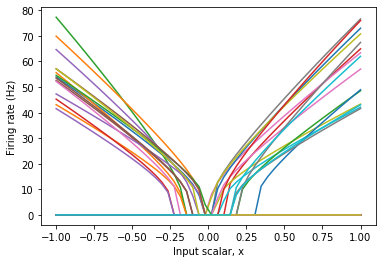

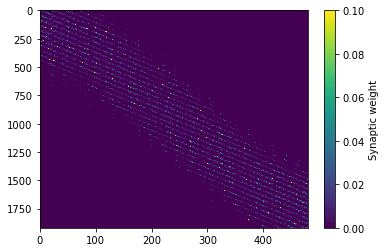

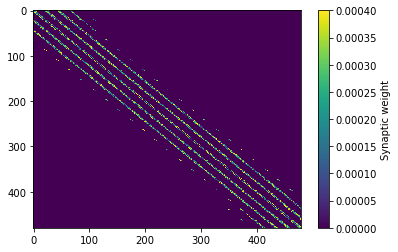

In [11]:
with nengo.Simulator(model) as sim:
    input_eval_points, input_activities = tuning_curves(input_ensemble.ea_ensembles[0], sim)

plt.plot(input_eval_points, input_activities)
plt.ylabel("Firing rate (Hz)")
plt.xlabel("Input scalar, x")    
plt.show()


plt.imshow(srf_network.weights_initial_E.T, aspect='auto', interpolation='nearest')
plt.colorbar(label='Synaptic weight')
plt.show()

if srf_network.weights_initial_EE is not None:
    plt.imshow(srf_network.weights_initial_EE.T, aspect='auto', interpolation='nearest')
    plt.colorbar(label='Synaptic weight')
    plt.show()


In [12]:
def run(model_dict, t_end, dt=0.001, kernel_tau=0.01, progress_bar=True):

    with nengo.Simulator(model_dict['model'], optimize=True, dt=dt,
                         progress_bar=TerminalProgressBar() if progress_bar else None) as sim:
        sim.run(np.max(t_end))

    p_srf_input = model_dict['neuron_probes']['srf_input']
    p_srf_output_spikes = model_dict['neuron_probes']['srf_output_spikes']
    p_srf_output_voltage = model_dict['neuron_probes']['srf_output_voltage']
    p_srf_exc_spikes = model_dict['neuron_probes']['srf_exc_spikes']
    p_srf_inh_spikes = model_dict['neuron_probes']['srf_inh_spikes']
    p_srf_exc_weights = model_dict['weight_probes']['srf_exc_weights']
    p_srf_inh_weights = model_dict['weight_probes']['srf_inh_weights']
    p_srf_rec_weights = model_dict['weight_probes']['srf_rec_weights']

    srf_rec_weights = sim.data.get(p_srf_rec_weights, None)
    srf_input = sim.data[p_srf_input]
    srf_exc_weights = sim.data[p_srf_exc_weights]
    srf_inh_weights = sim.data[p_srf_inh_weights]
    srf_output_spikes = sim.data[p_srf_output_spikes]
    srf_output_voltage = sim.data[p_srf_output_voltage]
    srf_exc_spikes = sim.data[p_srf_exc_spikes]
    srf_inh_spikes = sim.data[p_srf_inh_spikes]
    srf_exc_rates = rates_kernel(sim.trange(), sim.data[p_srf_exc_spikes], tau=kernel_tau)
    srf_inh_rates = rates_kernel(sim.trange(), sim.data[p_srf_inh_spikes], tau=kernel_tau)
    srf_output_rates = rates_kernel(sim.trange(), srf_output_spikes, tau=kernel_tau)

    return sim, {'srf_output_rates': srf_output_rates,
                 'srf_exc_rates': srf_exc_rates,
                 'srf_inh_rates': srf_inh_rates,
                 'srf_exc_spikes': srf_exc_spikes,
                 'srf_inh_spikes': srf_inh_spikes,
                 'srf_output_spikes': srf_output_spikes,
                 'srf_output_voltage': srf_output_voltage,
                 'srf_exc_weights': srf_exc_weights,
                 'srf_inh_weights': srf_inh_weights,
                 'srf_rec_weights': srf_rec_weights,
                 'srf_input': srf_input
            
    }


In [13]:

sim, sim_output_dict = run(model_dict, t_end, dt=dt)



Build finished in 0:00:01.                                                      
[                       Simulating... 0%                        ] ETA: Unknown

Simulation finished in 0:01:45.                                                 


In [14]:
srf_output_spikes_train = sim_output_dict['srf_output_spikes'][:n_steps_train]
srf_output_spikes_test = sim_output_dict['srf_output_spikes'][n_steps_train:]
    
srf_exc_spikes_train = sim_output_dict['srf_exc_spikes'][:n_steps_train]
srf_exc_spikes_test = sim_output_dict['srf_exc_spikes'][n_steps_train:]
    
srf_output_rates_train = sim_output_dict['srf_output_rates'][:n_steps_train]
srf_exc_rates_train = sim_output_dict['srf_exc_rates'][:n_steps_train]
srf_inh_rates_train = sim_output_dict['srf_inh_rates'][:n_steps_train]
    
srf_output_rates_test = sim_output_dict['srf_output_rates'][n_steps_train:]
srf_exc_rates_test = sim_output_dict['srf_exc_rates'][n_steps_train:]
srf_inh_rates_test = sim_output_dict['srf_inh_rates'][n_steps_train:]
    
srf_rec_weights = sim_output_dict['srf_rec_weights']
srf_exc_weights = sim_output_dict['srf_exc_weights']
srf_inh_weights = sim_output_dict['srf_inh_weights']

srf_output_voltage = sim_output_dict['srf_output_voltage']

ValueError: x and y must have same first dimension, but have shapes (323,) and (32, 2)

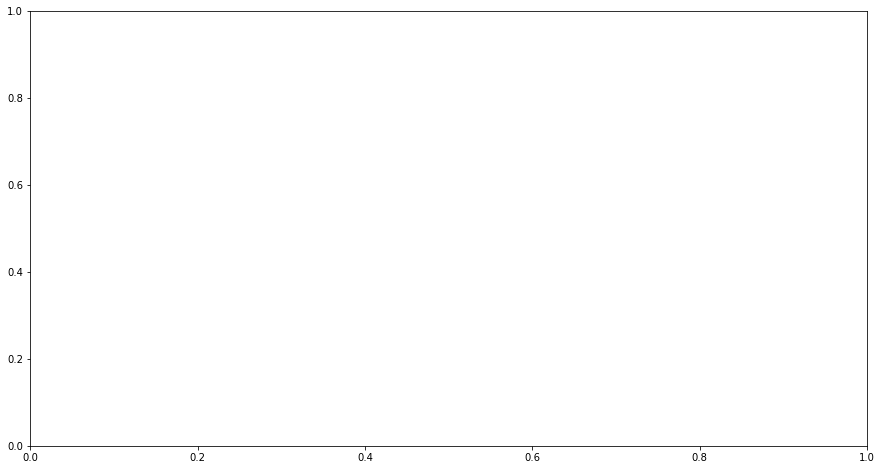

In [15]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(sim.trange().min(), sim.trange().max()-0.05, 0.05), srf_output_voltage[:,:2])
#plt.plot(sim_output_dict['srf_output_spikes'][:,:5])


plt.show()

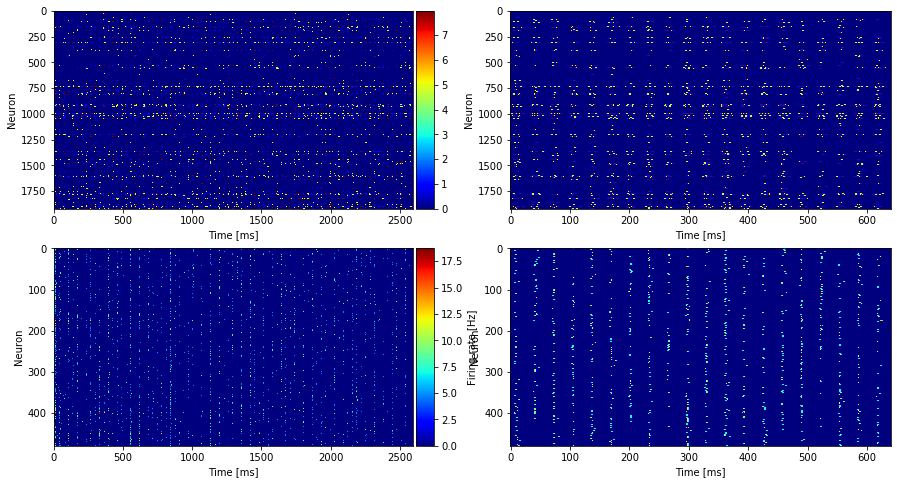

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,8))

im1 = axs[0,0].imshow(srf_exc_rates_train.T, aspect="auto", interpolation="nearest", cmap='jet')
divider1 = make_axes_locatable(axs[0,0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)
axs[0,0].set_xlabel('Time [ms]')
axs[0,0].set_ylabel('Neuron')

im2 = axs[0,1].imshow(srf_exc_rates_test.T, aspect="auto", interpolation="nearest", cmap='jet')
#cbar2 = plt.colorbar(im2, cax=axs[0,1], label='Firing rate [Hz]')
axs[0,1].set_xlabel('Time [ms]')
axs[0,1].set_ylabel('Neuron')

im3 = axs[1,0].imshow(srf_output_rates_train.T, aspect="auto", interpolation="nearest", cmap='jet')
divider3 = make_axes_locatable(axs[1,0])
axs[1,0].set_xlabel('Time [ms]')
axs[1,0].set_ylabel('Neuron')
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
cbar3 = plt.colorbar(im3, cax=cax3, label='Firing rate [Hz]')

im4 = axs[1,1].imshow(srf_output_rates_test.T, aspect="auto", interpolation="nearest", cmap='jet')
axs[1,1].set_xlabel('Time [ms]')
axs[1,1].set_ylabel('Neuron')
#cbar4 = plt.colorbar(im4, cax=axs[1,1], label='Firing rate [Hz]')

plt.show()


(12, 480)


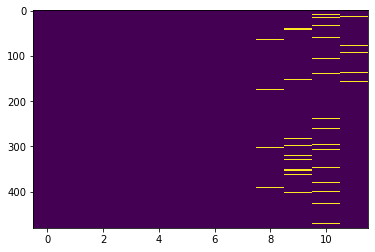

In [17]:
output_spikes_train = [x[n_steps_skip:n_steps_present]*dt
                       for x in np.split(srf_output_spikes_train[1*n_steps_frame:,:], (n_steps_train - 1*n_steps_frame)//n_steps_frame)]
output_spikes_test = [x[n_steps_skip:n_steps_present]*dt
                      for x in np.split(srf_output_spikes_test, n_steps_test/n_steps_frame)]

output_rates_train = np.split(srf_output_rates_train[1*n_steps_frame:,:],
                                  (n_steps_train - 1*n_steps_frame)//n_steps_frame)
output_rates_test = np.split(srf_output_rates_test, n_steps_test/n_steps_frame)


output_labels_train = train_labels[1:]
output_labels_test = test_labels

print(output_spikes_train[1].shape)
plt.imshow(output_spikes_test[1].T, aspect='auto', interpolation='nearest')


output_rates_train_array = np.swapaxes(np.stack(output_spikes_train,axis=0), 1, 2)
output_rates_test_array = np.swapaxes(np.stack(output_spikes_test,axis=0), 1, 2)


In [18]:
ngram_n = 2
ngram_decoder = fit_ngram_decoder(output_spikes_train, output_labels_train, n_labels, ngram_n, {}, dropout=None)
output_predictions_train = predict_ngram(output_spikes_train, ngram_decoder, n_labels, ngram_n)
output_predictions_test = predict_ngram(output_spikes_test, ngram_decoder, n_labels, ngram_n)
output_train_score = accuracy_score(output_labels_train, output_predictions_train)
output_test_score = accuracy_score(output_labels_test, output_predictions_test)
    
print(f'output_predictions_train = {output_predictions_train} output_train_score = {output_train_score}')
print(f'output_predictions_test = {output_predictions_test} output_test_score = {output_test_score}')


output_predictions_train = [8, 9, 2, 9, 8, 9, 5, 2, 6, 3, 2, 0, 6, 2, 9, 4, 2, 1, 0, 4, 0, 3, 2, 9, 5, 3, 9, 5, 0, 6, 1, 7, 5, 6, 5, 6, 5, 5, 1, 3, 3, 2, 8, 9, 0, 0, 1, 6, 5, 5, 4, 9, 0, 1, 6, 0, 7, 3, 7, 5, 5, 1, 1, 6, 4, 2, 7, 8, 3, 5, 3, 1, 1, 4, 6, 9, 4, 1, 9, 5] output_train_score = 1.0
output_predictions_test = [6, 3, 9, 2, 0, 5, 4, 6, 9, 5, 9, 5, 0, 5, 9, 0, 9, 9, 1, 5] output_test_score = 0.75


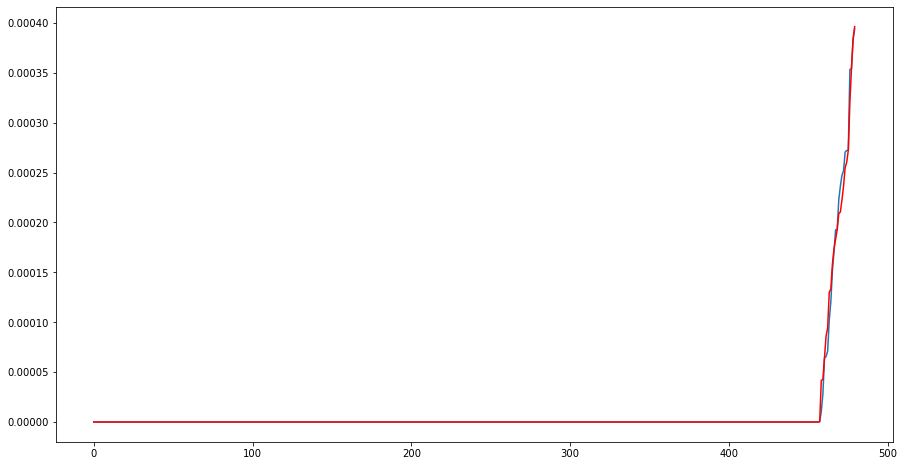

In [19]:
plt.figure(figsize=(15,8))
plt.plot(np.sort(srf_rec_weights[0][240]))
plt.plot(np.sort(srf_rec_weights[-1][240]),'r')
plt.show()

In [20]:
gid = 240
input_sources = np.nonzero(srf_network.weights_initial_E[gid,:])[0]
rec_input_sources = np.nonzero(srf_network.weights_initial_EE[gid,:])[0]


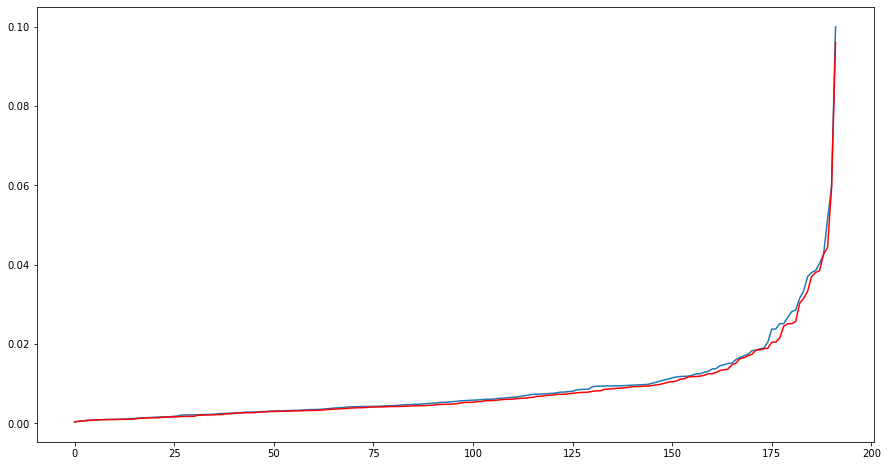

In [21]:
plt.figure(figsize=(15,8))
plt.plot(np.sort(srf_network.weights_initial_E[gid, input_sources].flat))
plt.plot(np.sort(srf_exc_weights[-1][gid][input_sources]),'r')

plt.show()

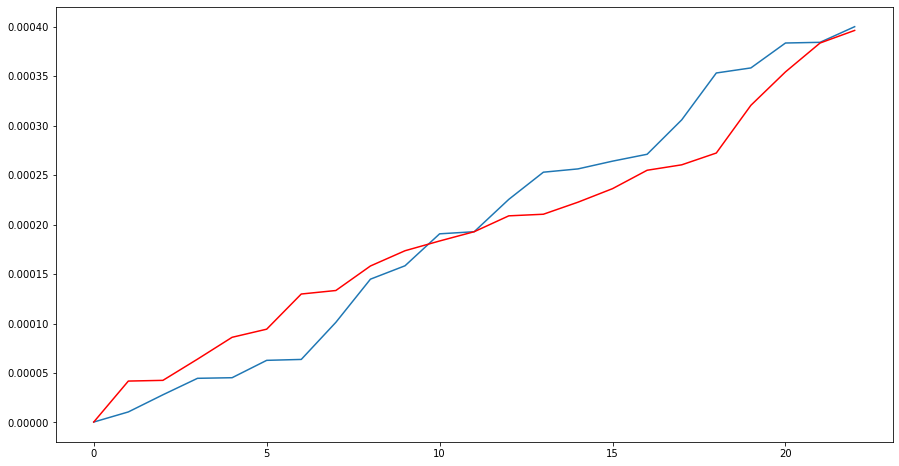

In [22]:
plt.figure(figsize=(15,8))
plt.plot(np.sort(srf_network.weights_initial_EE[gid, rec_input_sources].flat))
plt.plot(np.sort(srf_rec_weights[-1][gid][rec_input_sources]),'r')

plt.show()

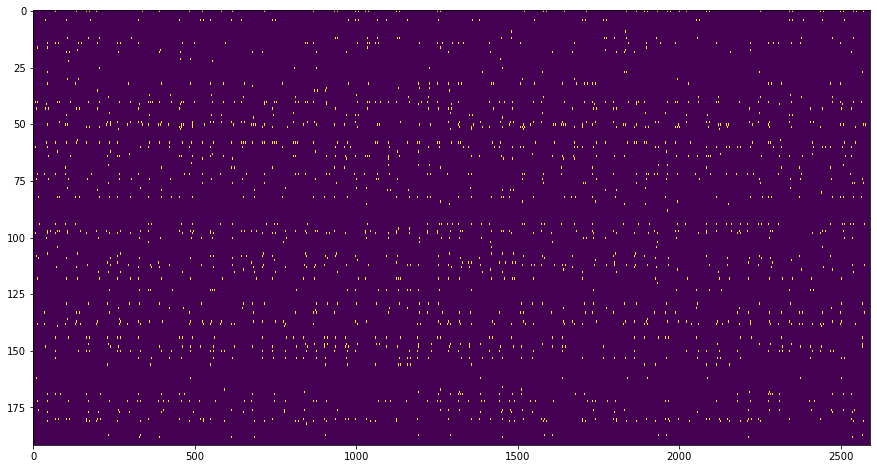

In [23]:
input_spikes_train = srf_exc_spikes_train[:,input_sources].reshape((-1,len(input_sources)))
plt.figure(figsize=(15,8))
plt.imshow(input_spikes_train.T,aspect='auto',interpolation='nearest')
plt.show()

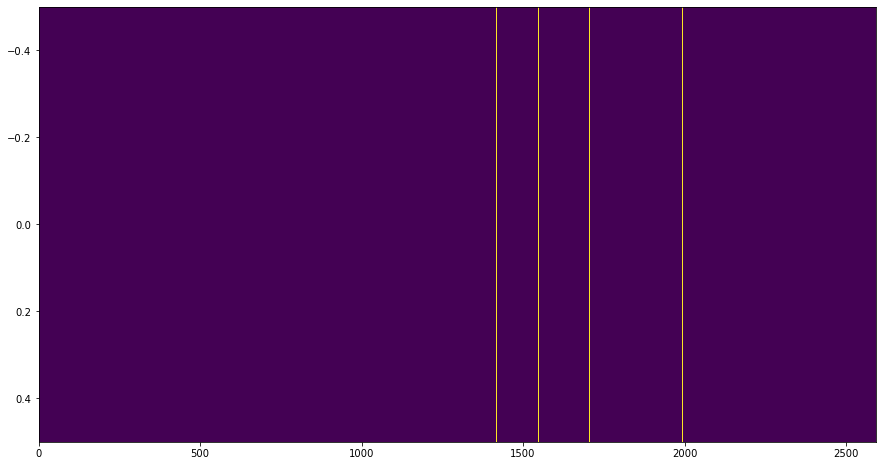

In [24]:
output_spikes_train = srf_output_spikes_train[:,gid].reshape((-1,1))
plt.figure(figsize=(15,8))
plt.imshow(output_spikes_train.T,aspect='auto',interpolation='nearest')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (323,) and (32,)

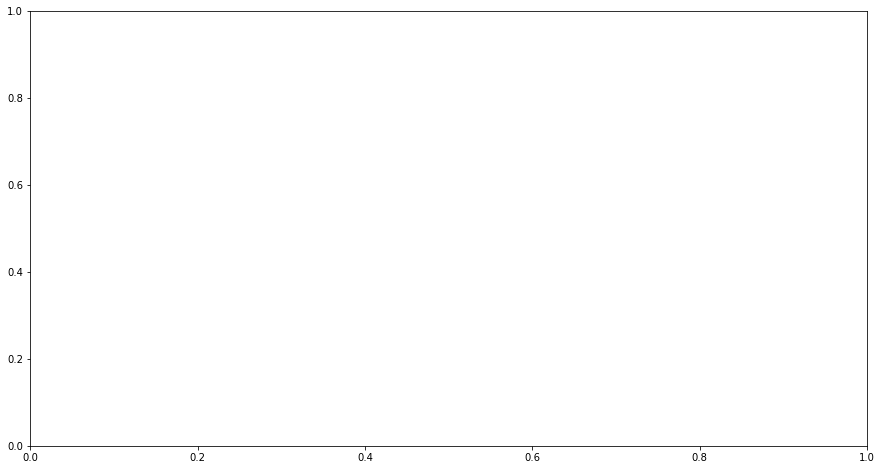

In [107]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(sim.trange().min(), sim.trange().max()-0.05, 0.05), srf_output_voltage[:,gid])
plt.show()

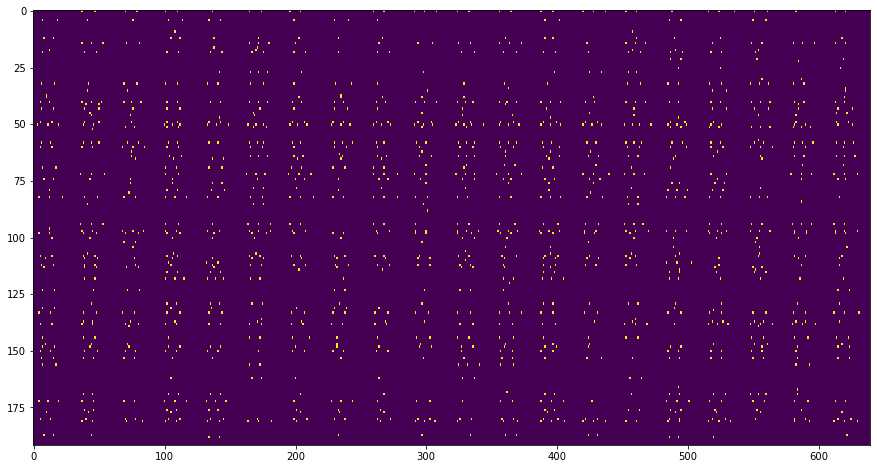

In [25]:
input_spikes_test = srf_exc_spikes_test[:,input_sources].reshape((-1,len(input_sources)))
plt.figure(figsize=(15,8))
plt.imshow(input_spikes_test.T,aspect='auto',interpolation='nearest')
plt.show()

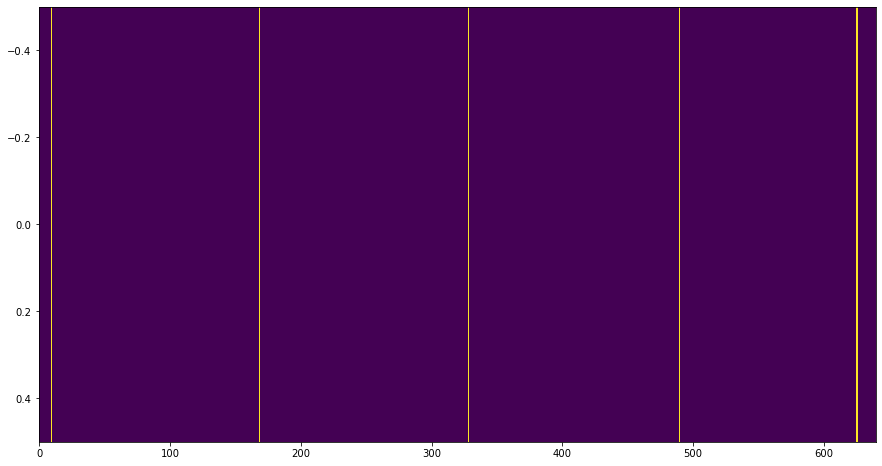

In [26]:
output_spikes_test = srf_output_spikes_test[:,gid].reshape((-1,1))
plt.figure(figsize=(15,8))
plt.imshow(output_spikes_test.T,aspect='auto',interpolation='nearest')
plt.show()